In [1]:


!pip install pydub

from google.colab import drive
drive.mount('/content/drive')

import os
from pydub import AudioSegment


CAPUCHIN_FILE =  "/content/drive/MyDrive/Parsed_Capuchinbird_Clips/XC3776-3.wav"
NOT_CAPUCHIN_FILE =  "/content/drive/MyDrive/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav"






Mounted at /content/drive


In [2]:
#!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib
!pip install tensorflow  tensorflow-io matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.0 MB/s eta 0:00:00


In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [4]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents=tf.io.read_file(filename)
    #Decode wav(tensors by channels)
    wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
    #Removes trailing axis
    wav=tf.squeeze(wav,axis=-1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    #Goes from 44100 Hz to 16000 Hz -amplitude of the audio signal
    wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav



In [5]:
#file_contents=tf.io.read_file(CAPUCHIN_FILE)


In [6]:
#file_contents

In [7]:
#wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)

In [8]:
#wav

In [9]:
#sample_rate

In [10]:
#len(wav)

In [11]:
#wav=tfio.audio.resample(wav,rate_in=44100,rate_out=16000)

In [12]:
#wav

In [13]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

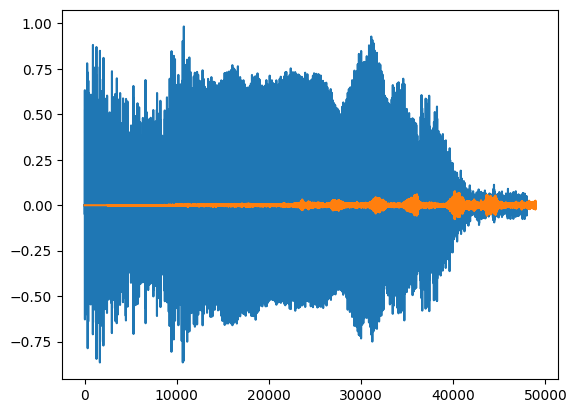

In [14]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [15]:
!pip install pydub

from google.colab import drive
drive.mount('/content/drive')

import os
from pydub import AudioSegment
POS =  "/content/drive/MyDrive/Parsed_Capuchinbird_Clips"
NEG= "/content/drive/MyDrive/Parsed_Not_Capuchinbird_Clips"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [17]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [18]:
os.listdir(POS)

['XC114132-2.wav',
 'XC114131-1.wav',
 'XC119294-0.wav',
 'XC114131-3.wav',
 'XC114132-0.wav',
 'XC114132-6.wav',
 'XC114131-2.wav',
 'XC114132-4.wav',
 'XC16804-1.wav',
 'XC16803-0.wav',
 'XC114131-0.wav',
 'XC16803-2.wav',
 'XC114132-1.wav',
 'XC16803-1.wav',
 'XC16804-0.wav',
 'XC114132-5.wav',
 'XC114132-3.wav',
 'XC114131-4.wav',
 'XC178168-4.wav',
 'XC178168-1.wav',
 'XC178167-2.wav',
 'XC168899-0.wav',
 'XC178168-2.wav',
 'XC178167-1.wav',
 'XC178167-0.wav',
 'XC178168-7.wav',
 'XC178168-0.wav',
 'XC178167-3.wav',
 'XC178168-6.wav',
 'XC178168-3.wav',
 'XC178168-5.wav',
 'XC201990-0.wav',
 'XC201990-2.wav',
 'XC201990-5.wav',
 'XC201990-4.wav',
 'XC216010-2.wav',
 'XC216010-4.wav',
 'XC201990-3.wav',
 'XC216010-3.wav',
 'XC216010-1.wav',
 'XC216010-5.wav',
 'XC216010-0.wav',
 'XC201990-1.wav',
 'XC216012-3.wav',
 'XC216012-13.wav',
 'XC216012-14.wav',
 'XC216012-0.wav',
 'XC216010-7.wav',
 'XC216012-16.wav',
 'XC216012-17.wav',
 'XC216012-1.wav',
 'XC216012-20.wav',
 'XC216012-1

In [19]:
lengths=[]
for file in os.listdir(POS):
    tensor_wave=load_wav_16k_mono(POS+'/'+file)
    lengths.append(len(tensor_wave))

In [20]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [21]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

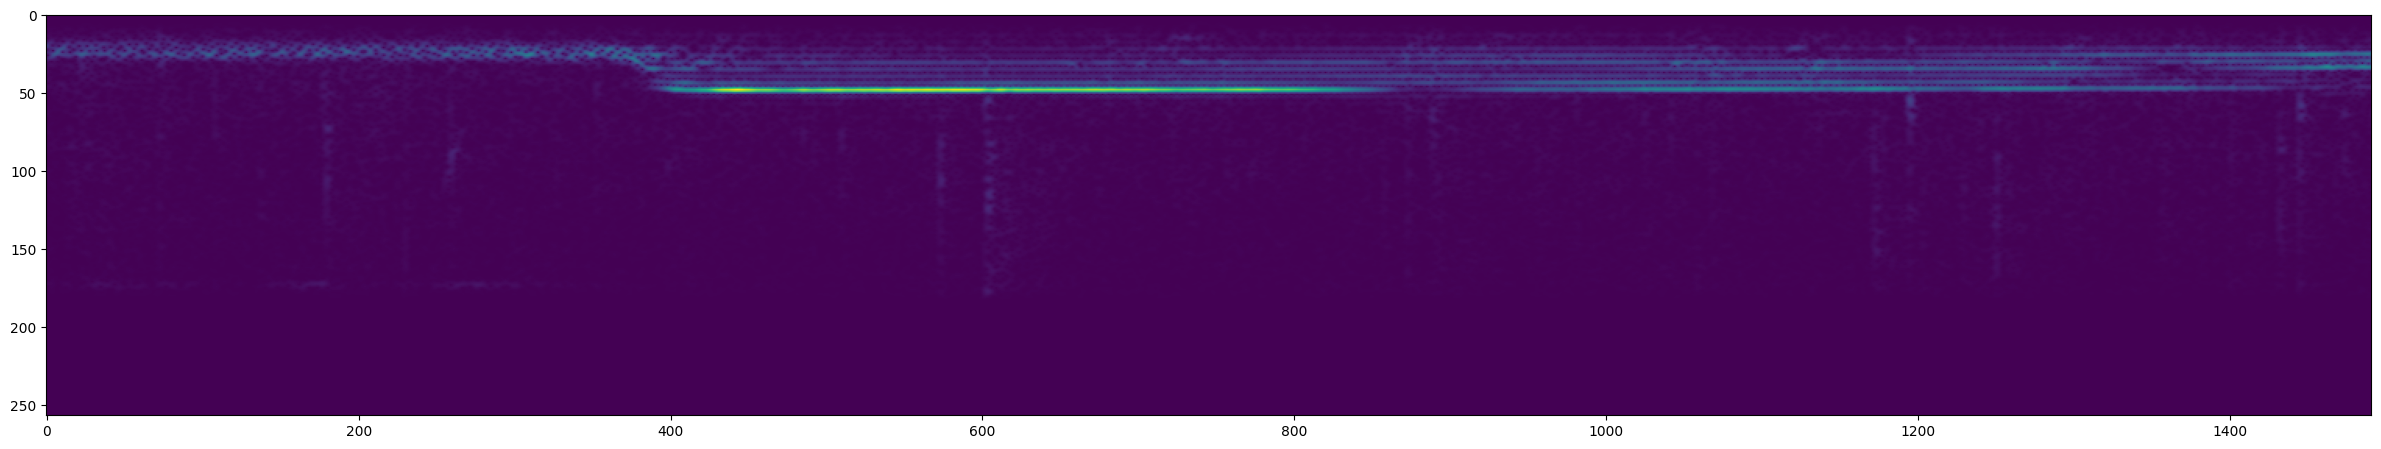

In [22]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [23]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [24]:
train = data.take(36)
test = data.skip(36).take(15)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [26]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1487, 253, 16)       │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6019376)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     770,480,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 770,482,865 (2.87 GB)

 Trainable params: 770,482,865 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# hist = model.fit(train, epochs=4, validation_data=test)

In [32]:
# plt.title('Loss')
# plt.plot(hist.history['loss'], 'r')
# plt.plot(hist.history['val_loss'], 'b')
# plt.show()

In [33]:
# plt.title('Precision')
# plt.plot(hist.history['precision'], 'r')
# plt.plot(hist.history['val_precision'], 'b')
# plt.show()
# plt.title('Recall')
# plt.plot(hist.history['recall'], 'r')
# plt.plot(hist.history['val_recall'], 'b')
# plt.show()

In [34]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [35]:
def load_mp3_16k_mono(filename):

    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [42]:
!pip install pydub

from google.colab import drive
drive.mount('/content/drive')

import os
from pydub import AudioSegment
mp3 =  "/content/drive/MyDrive/Forest Recordings/recording_00.mp3"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
wav = load_mp3_16k_mono(mp3)

In [44]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [45]:
samples, index = audio_slices.as_numpy_iterator().next()

In [46]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [48]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [49]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step


In [50]:
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [51]:
calls

46

In [54]:
results = {}
for file in os.listdir('/content/drive/MyDrive/Forest Recordings'):
    FILEPATH = os.path.join('/content/drive/MyDrive','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [55]:
results

{'recording_04.mp3': array([[0.49604037],
        [0.506521  ],
        [0.49748403],
        [0.49478358],
        [0.4453406 ],
        [0.5040159 ],
        [0.50214   ],
        [0.50816065],
        [0.50408363],
        [0.5040357 ],
        [0.5014409 ],
        [0.49904466],
        [0.4933957 ],
        [0.49974468],
        [0.50169146],
        [0.49995217],
        [0.49439588],
        [0.4955067 ],
        [0.50093305],
        [0.49490178],
        [0.4920501 ],
        [0.49988854],
        [0.49823472],
        [0.4990579 ],
        [0.50520563],
        [0.4946148 ],
        [0.5023699 ],
        [0.500921  ],
        [0.49763733],
        [0.49826235],
        [0.5000433 ],
        [0.5056404 ],
        [0.50470245],
        [0.50432926],
        [0.50467014],
        [0.5011127 ],
        [0.5002494 ],
        [0.49721897],
        [0.46735114],
        [0.4595895 ],
        [0.5002537 ],
        [0.49160028],
        [0.52264863],
        [0.45334747],
        [0.5

In [56]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_04.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_05.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_09.mp3': [0,
  0,
  0,
  

In [57]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_04.mp3': 0,
 'recording_05.mp3': 0,
 'recording_02.mp3': 0,
 'recording_09.mp3': 0,
 'recording_03.mp3': 0,
 'recording_01.mp3': 0,
 'recording_07.mp3': 0,
 'recording_08.mp3': 0,
 'recording_00.mp3': 0,
 'recording_06.mp3': 0,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_11.mp3': 0,
 'recording_15.mp3': 0,
 'recording_16.mp3': 0,
 'recording_10.mp3': 0,
 'recording_14.mp3': 0,
 'recording_25.mp3': 0,
 'recording_22.mp3': 0,
 'recording_21.mp3': 0,
 'recording_24.mp3': 0,
 'recording_17.mp3': 0,
 'recording_20.mp3': 0,
 'recording_26.mp3': 0,
 'recording_19.mp3': 0,
 'recording_18.mp3': 0,
 'recording_23.mp3': 0,
 'recording_27.mp3': 0,
 'recording_42.mp3': 0,
 'recording_43.mp3': 0,
 'recording_31.mp3': 0,
 'recording_40.mp3': 0,
 'recording_28.mp3': 0,
 'recording_38.mp3': 0,
 'recording_33.mp3': 0,
 'recording_30.mp3': 0,
 'recording_32.mp3': 0,
 'recording_39.mp3': 0,
 'recording_34.mp3': 0,
 'recording_41.mp3': 0,
 'recording_35.mp3': 0,
 'recording_29.m

In [58]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])